# Table of Contents

- [I. Import libraries](#I)
- [II. Import data](#II)
  - [1. Download data](#II.1)
  - [2. Import data](#II.2)
- [III. Clean data](#III)
- [IV. Time series model: Exponential Smoothing](#IV)

# I. Import libraries <a name="I"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os 
import warnings

from datetime import datetime, timedelta

from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [2]:
# Turn off warnings
warnings.filterwarnings("ignore")

# Set printed decimal limit
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plot theme
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16, 4)
custom_colors = ['#512d6d', '#e6a2b4', '#6b7d96', '#b3cde0']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# II. Import data <a name="II"></a>

## 1. Download data  <a name="II.1"></a>

In [3]:
file_id = "1atOZX3YXmxx-_QebbTfndeC6U_DPTL2e" # ID of the file on Google Drive
file_name = 'Updated_data_2021&2022.csv'

%run download.ipynb

## 2. Import data <a name="II.2"></a>

In [4]:
# File path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
file_path = os.path.join(parent_dir, 'Data',file_name)

df = pd.read_csv(file_path)
df.head()

,DATE_DIM,DAY_OF_WEEK,BET_ACCOUNT_NUM_HASH,AGE,AGE_BAND,GENDER,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
0,2021-01-01,Fri,13154,67.00,65+,M,11846,WA,37.00,NaN,1081.00,NaN,1118.00,443.55,271.25,288
1,2021-01-01,Fri,18379,54.00,45-54,M,1884,WA,40.00,NaN,NaN,NaN,40.00,0.00,40.00,1
2,2021-01-01,Fri,559232,63.00,55-64,M,2866,WA,NaN,NaN,12.00,NaN,12.00,9.50,2.04,5
3,2021-01-01,Fri,698904,69.00,65+,M,2100,WA,NaN,NaN,1223.50,NaN,1223.50,267.91,245.12,40
4,2021-01-01,Fri,762921,67.00,65+,M,4766,WA,NaN,NaN,17.50,NaN,17.50,0.00,3.50,5


# III. Clean data <a name="III"></a>

Based on our exploratory data analysis, we apply the similar steps to clean the data.

In [5]:
def clean_data(df):
    # DATE_DIM: datetime
    df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'], format='%Y-%m-%d')

    # BET_ACCOUNT_NUM_HASH: string
    df['BET_ACCOUNT_NUM_HASH'] = df['BET_ACCOUNT_NUM_HASH'].astype('O')

    # More than zero
    df = df[df['TOTAL_TURNOVER'] > 0]
    
    return df.set_index('DATE_DIM')[['BET_ACCOUNT_NUM_HASH', 'TOTAL_TURNOVER', 'TENURE_IN_DAYS']]

df = clean_data(df)
df.head()

,BET_ACCOUNT_NUM_HASH,TOTAL_TURNOVER,TENURE_IN_DAYS
DATE_DIM,,,
2021-01-01,13154,1118.00,11846
2021-01-01,18379,40.00,1884
2021-01-01,559232,12.00,2866
2021-01-01,698904,1223.50,2100
2021-01-01,762921,17.50,4766


# IV. Time series model: Exponential Smoothing <a name="IV"></a>

One of the downside of the predictive models above is that they do not factor in the time effects. Triple Exponential Smoothing, also known as Holt-Winters' Triple Exponential Smoothing, is a time series forecasting method that extends the concept of exponential smoothing to capture both trend and seasonality in the data. It is a popular technique used in various industries to make accurate predictions for time-dependent data.

In this particular case, daily trend can be acting at high variance. Therefore, we choose weekly granularity level. We run a triple exponential smoothing model with trend factor on all historical data and predict the next 4 week turnover spending of a customer.

In [6]:
# Define prediction period: Train set from  2021-01-04 (first Monday of the year) to 2021-05-10. Prediction/test set is from 2021-05-10 to from 2021-06-07
date = '2021-05-10'
future_date = (datetime.strptime(date, '%Y-%m-%d') + timedelta(weeks=4)).strftime('%Y-%m-%d')

# Filter train and test set accordingly to the period defined above
train_df = df[df.index < date]
test_df = df[(df.index >= date) & (df.index < future_date)]

# We filter out new customers who have not had at least 28 tenure days
cus = train_df.groupby('BET_ACCOUNT_NUM_HASH',as_index=False).TENURE_IN_DAYS.max()
legitimate_cus = cus.loc[cus['TENURE_IN_DAYS'] >= 28, 'BET_ACCOUNT_NUM_HASH']

# Filter train and test set accordingly to the period defined above
train_df = train_df[train_df['BET_ACCOUNT_NUM_HASH'].isin(legitimate_cus)]
test_df = test_df[test_df['BET_ACCOUNT_NUM_HASH'].isin(legitimate_cus)]

# Get result dataframe 
res = pd.DataFrame(columns = ['BET_ACCOUNT_NUM_HASH', 'real', 'pred'])
X_test = test_df.groupby('BET_ACCOUNT_NUM_HASH').TOTAL_TURNOVER.sum()

In [7]:
# Run Exponential Smoothing model on all 

for i in legitimate_cus: 
    # Filter customemean_squared_errorta
    cus_df = train_df[train_df['BET_ACCOUNT_NUM_HASH'] == i]

    # Resample train data into weekly granularity
    X_train = cus_df.resample('W').TOTAL_TURNOVER.sum()
    X_train = X_train.reindex(pd.date_range(start='2021-01-03',end=date, freq="W")).fillna(0)

    # Fit model
    exp_smth = ETSModel(X_train, trend = "add", freq='W')
    result = exp_smth.fit()

    # Forecast
    start = X_train.index[-1] + pd.DateOffset(weeks= 1)
    end = X_train.index[-1] + pd.DateOffset(weeks= 4)
    X_forecast = result.predict(start=start, end=end)

    try:
        real = X_test[i]
    except:
        real = 0

    # Append result
    pred = X_forecast.sum()
    res = res.append({'BET_ACCOUNT_NUM_HASH' : i, 'real':real, 'pred': pred if pred > 0 else 0}, ignore_index=True)

In [8]:
mse = mean_squared_error(res['real']/28,res['pred']/28)
mae = mean_absolute_error(res['real']/28,res['pred']/28)

eva_df = pd.DataFrame({"MSE":mse, "MAE":mae }, index=[0])
eva_df

,MSE,MAE
0,29623.28,30.15


Text(0.5, 1.0, 'Scatter plot: real vs pred')

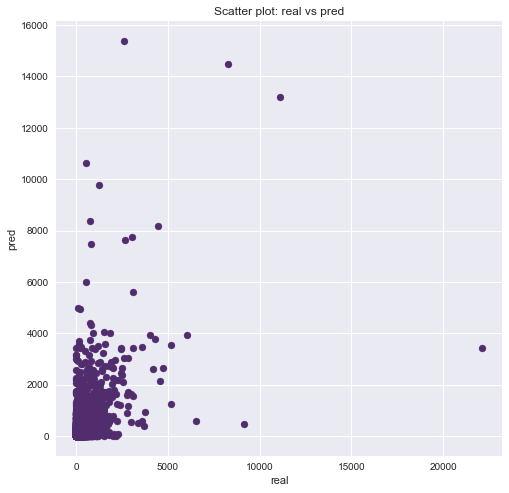

In [12]:
plt.figure(figsize = (8,8))
plt.scatter(res['real']/28, res['pred']/28)
plt.xlabel('real')
plt.ylabel('pred')
plt.title('Scatter plot: real vs pred')